#  SOCAT neural-network : TensorFlow with Keras API

This notebook contains all the code to run neural network using Tensorflow
Driver data includes: SST, SSS, MLD, CHL, CO2 and we are predicting fCO2

We are starting with monthly gridded observations 1998 - 2010

- Decent blog post on NN: http://blog.aloni.org/posts/backprop-with-tensorflow/

In [1]:
### Standard imports
%matplotlib inline
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os

### Tensorflow / Keras imports
# from tf.keras.models import Sequential  # This does not work!
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.python.keras.layers import Activation, Dropout

### sklearn imports
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.preprocessing import robust_scale
from sklearn.preprocessing import normalize
from sklearn.preprocessing import minmax_scale

### Print if using CPU or GPU
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [2]:
print('tensorflow version ',tf.__version__)
print('keras version ',tf.keras.__version__)
print('numpy version ',np.__version__)
print('xarray version ',xr.__version__)
print('pandas version ',pd.__version__)
print('sklearn version',sk.__version__)

tensorflow version  1.5.1
keras version  2.1.2-tf
numpy version  1.13.3
xarray version  0.10.2
pandas version  0.20.3
sklearn version 0.19.1


### All you need to change is data_dir

In [3]:
data_dir='/Users/gloege/Documents/Projects/SOCAT-neural-network/data/data_driver_fixed/'
os.listdir(data_dir)

['SOCATv5_mask_199801-201012.nc',
 'SALT_1x1_199801-201012.nc',
 'MXLDEPTH_1x1_199801-201012.nc',
 'co2_avg_199801-201012.nc',
 'sst_1x1_199801-201012.nc',
 'biomes.nc',
 'SOCATv5_gridded_monthly_199801-201012.nc',
 'Chl_1x1_199801-201012.nc']

# 1. Get the data and sample like it's SOCAT

In [4]:
### SOCAT data paths
fl_mask = data_dir + 'SOCATv5_mask_199801-201012.nc'
fl_socat = data_dir + 'SOCATv5_gridded_monthly_199801-201012.nc'

### Driver data paths
fl_sss = data_dir + 'SALT_1x1_199801-201012.nc'
fl_mld = data_dir + 'MXLDEPTH_1x1_199801-201012.nc'
fl_co2 = data_dir + 'co2_avg_199801-201012.nc'
fl_sst = data_dir + 'sst_1x1_199801-201012.nc'
fl_chl = data_dir + 'Chl_1x1_199801-201012.nc'

### biomes
fl_biomes = data_dir + 'biomes.nc'

In [5]:
### SOCAT data 
ds_mask = xr.open_dataset(fl_mask)
ds_socat = xr.open_dataset(fl_socat)

### Driver data
ds_sss = xr.open_dataset(fl_sss)
ds_mld = xr.open_dataset(fl_mld)
ds_co2 = xr.open_dataset(fl_co2)
ds_sst = xr.open_dataset(fl_sst)
ds_chl = xr.open_dataset(fl_chl)

### Biomes
ds_biomes = xr.open_dataset(fl_biomes)

In [6]:
### Make sure all the same dimensions
print('Make sure all same dimensions and lon starts at 0')
print(ds_mask['socat_mask'].shape, ds_mask['xlon'].values[0])
print(ds_socat['FCO2_AVE_UNWTD'].shape, ds_socat['xlon'].values[0])
print(ds_sss['SALT'].shape, ds_sss['tlon'].values[0])
print(ds_sst['sst'].shape, ds_sst['tlon'].values[0])
print(ds_chl['Chl'].shape, ds_chl['tlon'].values[0])
print(ds_mld['MXLDEPTH'].shape, ds_mld['tlon'].values[0])
print(ds_co2['co2'].shape) 


Make sure all same dimensions and lon starts at 0
(156, 180, 360) 0.5
(156, 180, 360) 0.5
(156, 180, 360) 0.5
(156, 180, 360) 0.5
(156, 180, 360) 0.5
(156, 180, 360) 0.5
(156,)


In [7]:
### Grid
lon = ds_socat['xlon']
lat = ds_socat['ylat']
time = ds_socat['tmnth']

### Data
mask = ds_mask['socat_mask'].values
fco2 = ds_socat['FCO2_AVE_UNWTD'].values
sss = ds_sss['SALT'].values
sst = ds_sst['sst'].values
chl = ds_chl['Chl'].values
mld = ds_mld['MXLDEPTH'].values

### This tiles CO2 so same shape as the others.
co2 = np.tile(ds_co2['co2'].values[:, np.newaxis, np.newaxis],(1,180,360))

### Show me the shape of co2
print('The shape of CO2 is now : ' + str(co2.shape))

The shape of CO2 is now : (156, 180, 360)


## One-hot encode the biomes

![mean_biomes](https://doi.pangaea.de/10013/epic.42948.d004)

In [8]:
### biomes
fl_biomes = data_dir + 'biomes.nc'

### Get Mean biomes and make lon 0-360
mean_biomes = np.swapaxes(ds_biomes['MeanBiomes'].roll(lon=-180),0,1).values

### biomes_tiled
biomes_tiled = np.tile(mean_biomes[np.newaxis, :, :],(len(time),1, 1))

### Replace nans with zero
biomes_land = np.isnan(mean_biomes)
mean_biomes[biomes_land] = 0

### Use tensorflow to one-hot encode
with tf.Session() as sess:
    biomes_one_hot = sess.run(tf.one_hot(mean_biomes,18))

### Tile biomes_one_hot
biomes_one_hot_tiled = np.tile(biomes_one_hot[np.newaxis, :, :, :],(len(time),1, 1, 1))

### plot one of the biomes
print(biomes_one_hot_tiled.shape)
# plt.pcolor(lon,lat,biomes_one_hot[:,:,4])

(156, 180, 360, 18)


## Tile lat lon and time

In [9]:
### Define a meshgrid from lon and lat
lon_mesh, lat_mesh = np.meshgrid(lon,lat)

### Tile the meshgrid to the number of time steps
lat_tiled = np.tile(lat_mesh[np.newaxis, :, :],(len(time),1, 1))
lon_tiled = np.tile(lon_mesh[np.newaxis, :, :],(len(time),1, 1))

### Tile time
time_tiled = np.tile(time.values[:, np.newaxis, np.newaxis],(1,180,360))
#time_tiled.shape

## Mask the data like it is SOCAT

In [10]:
fco2_ma = np.ma.masked_array(fco2, mask=(mask==0))

sst_ma = np.ma.masked_array(sst, mask=(mask==0))
sss_ma = np.ma.masked_array(sss, mask=(mask==0))
chl_ma = np.ma.masked_array(chl, mask=(mask==0))
mld_ma = np.ma.masked_array(mld, mask=(mask==0))
co2_ma = np.ma.masked_array(co2, mask=(mask==0))

lon_ma = np.ma.masked_array(lon_tiled, mask=(mask==0))
lat_ma = np.ma.masked_array(lat_tiled, mask=(mask==0))

## Driver data in large matrix and output

In [11]:
### What is driving the model
                                ### "classic" predictors
driver = np.transpose(np.stack((sst_ma.flatten(),     # SST
                                sss_ma.flatten(),     # SSS 
                                chl_ma.flatten(),     # Chl
                                mld_ma.flatten(),     # MLD
                                co2_ma.flatten(),     # atm. CO2
                                
                                ### Grid as predictors
                                lon_ma.flatten(),  # Longitude
                                lat_ma.flatten(),  # Latitude
                                #time_tiled.flatten(), # time
                                
                                ### Biomes are one-hot encoded ###
                                #biomes_one_hot_tiled[:,:,:,0].flatten(), # <-- This one is 1 where there is land
                                #biomes_one_hot_tiled[:,:,:,1].flatten(),
                                #biomes_one_hot_tiled[:,:,:,2].flatten(),
                                #biomes_one_hot_tiled[:,:,:,3].flatten(),
                                #biomes_one_hot_tiled[:,:,:,4].flatten(),
                                #biomes_one_hot_tiled[:,:,:,5].flatten(),
                                #biomes_one_hot_tiled[:,:,:,6].flatten(),
                                #biomes_one_hot_tiled[:,:,:,7].flatten(),
                                #biomes_one_hot_tiled[:,:,:,8].flatten(),
                                #biomes_one_hot_tiled[:,:,:,9].flatten(),
                                #biomes_one_hot_tiled[:,:,:,10].flatten(),
                                #biomes_one_hot_tiled[:,:,:,11].flatten(),
                                #biomes_one_hot_tiled[:,:,:,12].flatten(),
                                #biomes_one_hot_tiled[:,:,:,13].flatten(),
                                #biomes_one_hot_tiled[:,:,:,14].flatten(),
                                #biomes_one_hot_tiled[:,:,:,15].flatten(),
                                #biomes_one_hot_tiled[:,:,:,16].flatten(),
                                #biomes_one_hot_tiled[:,:,:,17].flatten(),
                                
                                ### Output (what you are trying to predict)
                                fco2_ma.flatten() # SOCAT fCO2
                               ))) 

### What the true value is 
#true_value = fco2_ma.flatten()

print('shape of driver: ' + str(driver.shape))
#print('shape of true_value: ' + str(true_value.shape))

shape of driver: (10108800, 8)


## Remove rows with NaN and train/test split
I am calling these driver_nn and true_value_nn

In [12]:
df_driver = pd.DataFrame(driver).dropna(axis=0)
#df_driver_dropna = df_driver.dropna(axis=0)
df_driver.head()

### if you want a specific biome
# df_driver_biome = df_driver_dropna.loc[df_driver_dropna[8] == 1]
# df_driver_biome.head()

,0,1,2,3,4,5,6,7
4485,-1.79,34.004675,0.63170,20.346722,365.0734,165.5,-77.5,211.853287
4486,-1.79,34.000382,1.05912,18.216934,365.0734,166.5,-77.5,146.925980
4487,-1.79,33.951115,0.47567,15.844231,365.0734,167.5,-77.5,69.547241
4488,-1.79,33.890442,0.53423,13.237171,365.0734,168.5,-77.5,217.278625
4491,-1.79,33.939174,0.40530,14.088153,365.0734,171.5,-77.5,305.346130


In [13]:
features = df_driver.iloc[:,0:7].as_matrix()
output = df_driver.iloc[:,-1].as_matrix()
print('shape of features ',features.shape)
print('shape of output ',output.shape)

shape of features  (113712, 7)
shape of output  (113712,)


## Remove extreme outliers

In [281]:
#inds, = np.where(output>900)
#output[inds]

#df_driver[df_driver[:,-1] > 1000]
#df_driver
#features=features.drop(features.index[inds])
#features.index[inds]
#output[inds]
#features = df_driver.iloc[:,0:7].as_matrix()
#output = df_driver.iloc[:,-1].as_matrix()
#print('shape of features ',features.shape)
#print('shape of output ',output.shape)

4485        211.853287
4486        146.925980
4487         69.547241
4488        217.278625
4491        305.346130
4492        283.115051
4493        269.453827
4494        276.633698
4495        274.948395
4496        270.058716
4497        277.225067
4499        273.899536
4500        242.508377
4501        258.082336
4502        234.389877
4847         79.858307
4848        167.151489
4849        245.542191
4850        251.666870
4851        285.481537
4852        282.233765
4853        268.385895
4854        275.526886
4855        277.234619
4856        264.494202
4857        264.556763
4860        269.496216
5204        243.353622
5205        245.002441
5206        275.891174
               ...    
10089338    349.826477
10089344    349.574432
10089501    330.004883
10089509    334.072510
10089668    348.574249
10089669    350.421570
10089691    344.498871
10089692    344.944000
10089698    350.085388
10089699    349.226288
10089705    351.016144
10089861    324.681793
10089869   

In [14]:
X_train, X_test, y_train, y_test = train_test_split(features, output[:, np.newaxis], random_state=42)
y_train = np.array(y_train)
y_test =  np.array(y_test)
X_train = np.array(X_train)
X_test =  np.array(X_test)

print('shape of X_train: ' + str(X_train.shape))
print('shape of X_test: ' + str(X_test.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of y_test: ' + str(y_test.shape))

shape of X_train: (85284, 7)
shape of X_test: (28428, 7)
shape of y_train: (85284, 1)
shape of y_test: (28428, 1)


### Save train and test set for Nick

In [15]:
np.savetxt('predictors_train.txt', X = X_train, delimiter = ',')
np.savetxt('fco2_train.txt', X = y_train, delimiter = ',')

np.savetxt('predictors_test.txt', X = X_test, delimiter = ',')
np.savetxt('fco2_test.txt', X = y_test, delimiter = ',')

# Scale the data

In [16]:
X_train_scale = normalize(X_train, axis=1)
y_train_scale, y_train_norm = normalize(y_train, axis=0, return_norm=True)

X_test_scale = normalize(X_test, axis=1)
y_test_scale, y_test_norm = normalize(y_test, axis=0, return_norm=True)

print(np.min(X_train_scale), np.max(X_train_scale))
print(np.min(y_train_scale), np.max(y_train_scale))

-0.18894067383 0.993793625736
0.000665771607821 0.0394258893565


In [244]:
inds = np.where(y_train>900)
inds

(array([   43,  2275, 10737, 30417, 37923, 38742]), array([0, 0, 0, 0, 0, 0]))


# 2. Neural Network - tensorflow / keras API

Keras is a high level API using tensorflow as a backend. I have found this be very well documented, simple to use, and fits my machine learning needs. Pure tensorflow is great, but not well documented and there are many API's that are all in development. I am not sure which one the community will support. I am in favor of keras.
- Keras documentation: https://keras.io
- tf.keras doc: https://www.tensorflow.org/api_docs/python/tf/keras
- nice notebook: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/03C_Keras_API.ipynb

## Define architecture

In [234]:
### Gets the number of features (just number columns in driver)
n_features = np.shape(X_train_scale)[1]

### Model architecture
model = Sequential()
model.add(Dense(100, input_shape=(n_features,), 
                activation='relu',
#                kernel_regularizer=keras.regularizers.l2(0.0001),
                use_bias=True))
model.add(Dense(50, 
                activation='relu',
#                kernel_regularizer=keras.regularizers.l2(0.0001),
                use_bias=True))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

### Show topogarphy
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 100)               800       
_________________________________________________________________
dense_51 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 51        
Total params: 5,901
Trainable params: 5,901
Non-trainable params: 0
_________________________________________________________________


## Compile

In [235]:
## Optimizer
learning_rate = 1e-3
optimizer = keras.optimizers.Adam(lr=learning_rate)

### Compile the model
model.compile(optimizer=optimizer, 
              loss='mse',
              metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'])

## Training / Validation

In [236]:
history_callback = model.fit(X_train_scale, 
                             y_train, 
                             validation_split=0.1,
                             epochs=10,
                             batch_size=50,
                             verbose=1)

Train on 76755 samples, validate on 8529 samples
Epoch 1/10
76755/76755 [==============================]76755/76755 [==============================] - 3s 42us/step - loss: 16977.9822 - mean_squared_error: 16977.9822 - mean_absolute_error: 74.1902 - mean_absolute_percentage_error: 21.0714 - val_loss: 1353.8620 - val_mean_squared_error: 1353.8620 - val_mean_absolute_error: 26.9501 - val_mean_absolute_percentage_error: 7.9127

Epoch 2/10
76755/76755 [==============================]76755/76755 [==============================] - 3s 35us/step - loss: 1596.2016 - mean_squared_error: 1596.2016 - mean_absolute_error: 26.7565 - mean_absolute_percentage_error: 7.8397 - val_loss: 1275.0887 - val_mean_squared_error: 1275.0887 - val_mean_absolute_error: 25.8400 - val_mean_absolute_percentage_error: 7.5645

Epoch 3/10
76755/76755 [==============================]76755/76755 [==============================] - 3s 35us/step - loss: 1520.3429 - mean_squared_error: 1520.3429 - mean_absolute_error: 25.9164 

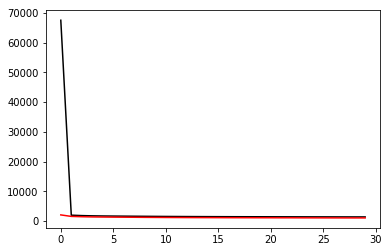

In [229]:
plt.plot(history_callback.history['mean_squared_error'], color='k')
plt.plot(history_callback.history['val_mean_squared_error'], color='r')

In [230]:
print(history_callback.history['mean_squared_error'][-1])
print(history_callback.history['val_mean_squared_error'][-1])

1407.00209331
1074.53721294


## Evaluation

In [231]:
result = model.evaluate(x=X_test_scale,
                        y=y_test)

28428/28428 [==============================]28428/28428 [==============================] - 1s 28us/step



In [232]:
for name, value in zip(model.metrics_names, result):
    print(name, value)
    if name=='mean_squared_error':
        print('mean_error ',np.sqrt(value))

loss 1104.8102349
mean_squared_error 1104.8102349
mean_error  33.2386858178
mean_absolute_error 23.5870205914
mean_absolute_percentage_error 6.84115188864


## Cross plot predictions and actual

In [193]:
pred = model.predict(X_test_scale, verbose=1)

28428/28428 [==============================]28428/28428 [==============================] - 1s 18us/step



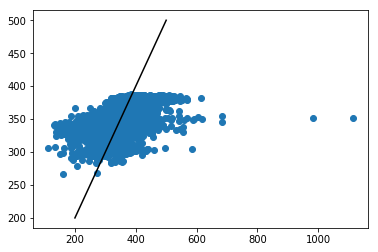

In [194]:
limit=[np.floor(np.min(y_test)), np.ceil(np.max(y_test))]
plt.scatter(y_test, pred)
plt.plot([200, 500],[200, 500],color='k')
#plt.xlim(limit)
#plt.ylim(limit)
plt.show()